# So overall, this is the same as the binary classifier from the first binary classifier, except we also have shorting as well

In this case, we would be executing  trades risking 2% in total of our capital when to buy and when to short. That way we will also make sure not to loose our total capital in general, and we will also simulate liquidation. Meaning, any other stuff that was updated in the first binary classifier we go over and put it in this classifier as well

**Rules:**
-Preprocess the data
-Define model architecture
-Train the model and feed the data to it
-F1-Score & Backtesting

**Live simulation---**
Best to do 50 iterations for all tests in general, look at your python script on your desktop to execute, load, and run them all, after cleaning what needs to be done. Mind you any metatrader5 data we are fetching is being simulated here, nothign is being reflected within our account. 

In [2]:
#making sure we train with our GPU, Pytorch is the fucking shit!!!
import torch
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device(0)

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA TITAN RTX'

In [7]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import os
import warnings

# Set multiprocessing method
torch.multiprocessing.set_start_method('spawn', force=True)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Custom Dataset class with exception handling
class BitcoinDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        try:
            features = self.features[idx]
            label = self.labels[idx]
            return features, label
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            return torch.tensor([]), torch.tensor([])  # Return empty tensors on error

# Load the preprocessed data
data_paths = {
    '1': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexh4_cleaned.csv',
    '2': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexh6_cleaned.csv',
    '3': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexh8_cleaned.csv',
    '4': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexh12_cleaned.csv',
    '5': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexh1_cleaned.csv',
    '6': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexh2_cleaned.csv',
    '7': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexh3_cleaned.csv',
    '8': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexm15_cleaned.csv',
    '9': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexm30_cleaned.csv',
    '10': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexm115_cleaned.csv',
    '11': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexm5_cleaned.csv',
    '12': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexm1_1_cleaned.csv',
    '13': 'C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/forexm1_2_cleaned.csv'
}


# Function to load and concatenate datasets
def load_data(data_paths):
    data_frames = []
    for key, path in data_paths.items():
        df = pd.read_csv(path, dtype={'DateTime': str})  # Specify dtype for 'DateTime' column
        df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')  # Convert 'DateTime' to datetime
        df = df.set_index('DateTime')
        data_frames.append(df)
    combined_data = pd.concat(data_frames, axis=0)
    return combined_data

# Load and combine datasets
combined_data = load_data(data_paths)

# Debug: print the shape of the combined data
print(f"Combined data shape: {combined_data.shape}")

# Debug: check for NaNs in the data
nan_info = combined_data.isna().sum()
print("NaN values in each column:\n", nan_info)

# Drop columns that are completely NaN
columns_to_drop = [f'Unnamed: {i}' for i in range(13, 36)]
combined_data.drop(columns=columns_to_drop, inplace=True)

# Option 2: Fill NaNs in 'Up_Or_Down' with a default value (e.g., 0)
# combined_data['Up_Or_Down'].fillna(0, inplace=True)

# Debug: print the shape of the combined data after handling NaNs
print(f"Combined data shape after handling NaNs: {combined_data.shape}")

# Separate features and labels
features = combined_data.drop(columns=['Buy_Signal', 'Sell_Signal']).values
buy_labels = combined_data['Buy_Signal'].values
sell_labels = combined_data['Sell_Signal'].values

# Debug: print the shapes of features and labels
print(f"Features shape: {features.shape}, Buy labels shape: {buy_labels.shape}, Sell labels shape: {sell_labels.shape}")

# Split the data
train_features, test_features, train_buy_labels, test_buy_labels, train_sell_labels, test_sell_labels = train_test_split(
    features, buy_labels, sell_labels, test_size=0.2, shuffle=False)
train_features, val_features, train_buy_labels, val_buy_labels, train_sell_labels, val_sell_labels = train_test_split(
    train_features, train_buy_labels, train_sell_labels, test_size=0.2, shuffle=False)

# Standardize the data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# Check data for NaNs and infinities
def check_data_for_nans(features, labels):
    if np.isnan(features).any() or np.isnan(labels).any():
        raise ValueError("Data contains NaNs")
    if np.isinf(features).any() or np.isinf(labels).any():
        raise ValueError("Data contains infinite values")

# Check training and validation data
check_data_for_nans(train_features, train_buy_labels)
check_data_for_nans(val_features, val_buy_labels)

# Create DataLoader function with conditional persistent_workers
def create_dataloader(features, labels, batch_size=3072, shuffle=True, num_workers=0):
    dataset = BitcoinDataset(features, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True,
                            persistent_workers=num_workers > 0)
    return dataloader

# Define batch_size
batch_size = 3072  # Adjust to fit GPU memory

# Create DataLoaders for buy signals
train_buy_loader = create_dataloader(train_features, train_buy_labels, batch_size, num_workers=0)
val_buy_loader = create_dataloader(val_features, val_buy_labels, batch_size, num_workers=0)
test_buy_loader = create_dataloader(test_features, test_buy_labels, batch_size, num_workers=0)

# Create DataLoaders for sell signals
train_sell_loader = create_dataloader(train_features, train_sell_labels, batch_size, num_workers=0)
val_sell_loader = create_dataloader(val_features, val_sell_labels, batch_size, num_workers=0)
test_sell_loader = create_dataloader(test_features, test_sell_labels, batch_size, num_workers=0)

print("Data Loaders created successfully!")

# Set the device for training (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Combined data shape: (14074179, 35)
NaN values in each column:
 OPEN                                 0
HIGH                                 0
LOW                                  0
CLOSE                                0
TICKVOL                              0
VOL                                  0
SPREAD                               0
Change_Open_Close                    0
Change_High_Low                      0
Profit_Between_Time_Series           0
Buy_Signal                           0
Sell_Signal                          0
Unnamed: 13                   14074179
Unnamed: 14                   14074179
Unnamed: 15                   14074179
Unnamed: 16                   14074179
Unnamed: 17                   14074179
Unnamed: 18                   14074179
Unnamed: 19                   14074179
Unnamed: 20                   14074179
Unnamed: 21                   14074179
Unnamed: 22                   14074179
Unnamed: 23                   14074179
Unnamed: 24                   14074179


In [8]:
import torch.nn as nn
import torch.optim as optim
import torch

# Define the RNN model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Model parameters
input_size = combined_data.shape[1] - 2  # Number of features (exclude 'Buy_Signal' and 'Sell_Signal')
hidden_size = 256  # Reduced hidden size
num_layers = 4  # Reduced number of layers
output_size = 2  # Binary classification (up or down)

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Initialize the model, loss function, and optimizer
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.5).to(device)

# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)

model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  # Use standard Adam
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

print("Model, loss function, and optimizer created successfully!")


CUDA is available. Using GPU.
Device name: NVIDIA TITAN RTX
Model, loss function, and optimizer created successfully!


In [10]:
# Function to count the number of parameters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in the model
num_params = count_parameters(model)
print(f'The model has {num_params:,} trainable parameters')

The model has 2,116,866 trainable parameters


Epoch 1/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:49<00:00, 26.78batch/s]


Epoch 1/20, Loss: 0.0869, Val Loss: 0.0297, Time: 137.56s


Epoch 2/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:55<00:00, 25.39batch/s]


Epoch 2/20, Loss: 0.0626, Val Loss: 0.0405, Time: 142.80s


Epoch 3/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:51<00:00, 26.25batch/s]


Epoch 3/20, Loss: 0.0594, Val Loss: 0.0363, Time: 138.58s


Epoch 4/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:52<00:00, 26.11batch/s]


Epoch 4/20, Loss: 0.0572, Val Loss: 0.0517, Time: 138.87s


Epoch 5/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:50<00:00, 26.45batch/s]


Epoch 5/20, Loss: 0.0554, Val Loss: 0.0467, Time: 137.81s


Epoch 6/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:51<00:00, 26.29batch/s]


Epoch 6/20, Loss: 0.0524, Val Loss: 0.0430, Time: 138.17s


Epoch 7/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:50<00:00, 26.49batch/s]


Epoch 7/20, Loss: 0.0517, Val Loss: 0.0531, Time: 136.78s


Epoch 8/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:51<00:00, 26.23batch/s]


Epoch 8/20, Loss: 0.0511, Val Loss: 0.0520, Time: 138.97s


Epoch 9/20: 100%|███████████████████████████████████████████████████████████████| 2933/2933 [01:52<00:00, 26.18batch/s]


Epoch 9/20, Loss: 0.0507, Val Loss: 0.0501, Time: 138.58s


Epoch 10/20: 100%|██████████████████████████████████████████████████████████████| 2933/2933 [01:50<00:00, 26.53batch/s]


Epoch 10/20, Loss: 0.0490, Val Loss: 0.0412, Time: 138.32s


Epoch 11/20: 100%|██████████████████████████████████████████████████████████████| 2933/2933 [01:51<00:00, 26.37batch/s]


Epoch 11/20, Loss: 0.0488, Val Loss: 0.0453, Time: 135.69s
Early stopping


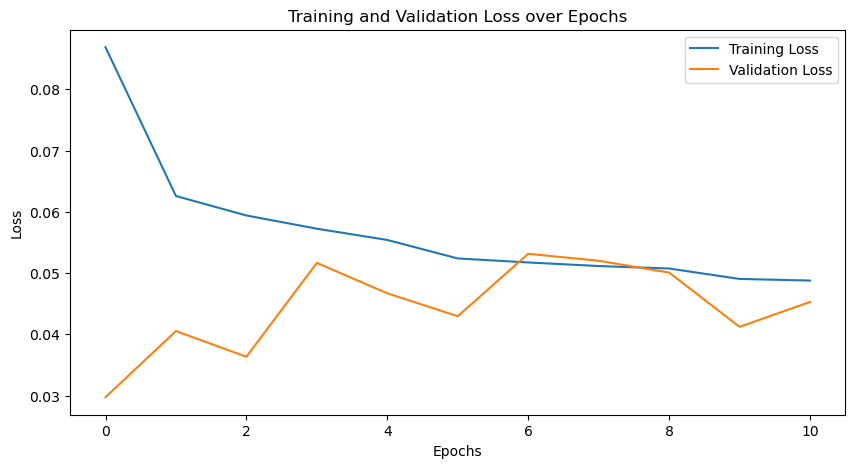

In [11]:
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

# Ensure the model is moved to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = validate_model(model, val_loader, criterion)
        
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f}s")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                model.load_state_dict(torch.load('best_model.pth'))
                break
    
    return train_losses, val_losses

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with autocast():
                outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    
    val_loss = running_loss / len(val_loader.dataset)
    return val_loss

# Plot loss function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

# Number of epochs for training
num_epochs = 20

# Example usage:
# Assuming train_buy_loader, val_buy_loader, criterion, optimizer, and scheduler are already defined

# Train the model and get the losses
train_losses, val_losses = train_model(model, train_buy_loader, val_buy_loader, criterion, optimizer, scheduler, num_epochs, patience=10)

# Plot the losses
plot_losses(train_losses, val_losses)


Test Loss: 0.0392
Accuracy: 0.9829
Precision: 1.0000
Recall: 0.9253
F1 Score: 0.9612


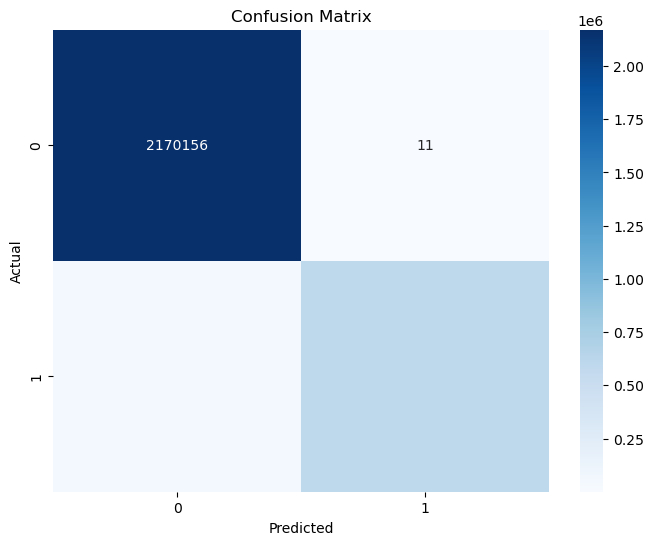

In [12]:
#F1 Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs.unsqueeze(1))  # Add batch dimension for LSTM
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    test_loss = running_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    
    return all_labels, all_preds

# Evaluate on test_buy_loader or test_sell_loader depending on your focus
all_labels, all_preds = evaluate_model(model, test_buy_loader, criterion)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
#Save the model:
import torch

# Save the entire model
torch.save(model, 'forexmodel-2.pth')

In [14]:
# Save the model
torch.save(model.state_dict(), 'forexmodel-2.pth')
print("Model saved successfully!")

Model saved successfully!


In [3]:
!pip install MetaTrader5

import os
import shutil
import MetaTrader5 as mt5
import pandas as pd
import datetime
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the RNN model
class BitcoinPriceLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(BitcoinPriceLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters (ensure these match the training script)
input_size = 10  # Adjusted to match the training script
hidden_size = 256  # Match with the training script
num_layers = 4  # Match with the training script
output_size = 2  # Binary classification (up or down)

# Load the trained model
model_path = "C:/Users/gunne/Documents/PriceNeuralNetwork/Forex/binarymodel2/forexmodel-2.pth"
model = BitcoinPriceLSTM(input_size, hidden_size, num_layers, output_size, dropout=0.5).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# Connect to MetaTrader 5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader 5 initialized successfully")

# Login to the demo account
account = 51806647  # Ensure the account number is an integer
password = "lKDtOjEK6$rp@f"
server = "ICMarketsSC-Demo"

# Debug print for login details
print(f"Attempting to login with Account: {account}, Password: {password}, Server: {server}")

authorized = mt5.login(login=account, password=password, server=server)
if not authorized:
    print(f"Failed to connect to account #{account}, error code: {mt5.last_error()}")
else:
    print(f"Connected to account #{account}")


MetaTrader 5 initialized successfully
Attempting to login with Account: 51806647, Password: lKDtOjEK6$rp@f, Server: ICMarketsSC-Demo
Connected to account #51806647


In [ ]:
#Trading strategy and logs:
#Now lets do this with the dummy money traded with our account, part 2:
# Trading parameters
initial_capital = 100
capital = initial_capital
leverage = 200  # 1:200 leverage
profit_cap_percentage = 0.1  # Daily profit target of 0.1%
stop_loss_percentage = -0.1  # Stop loss at -0.1%
target_capital = 200000
positions = 0
entry_price = None

# Create directories for logging
base_log_dir = "trading_logs"
os.makedirs(base_log_dir, exist_ok=True)

# Create a new folder for the current test
current_test_index = 0
while os.path.exists(os.path.join(base_log_dir, f"test_{current_test_index}")):
    current_test_index += 1

current_log_dir = os.path.join(base_log_dir, f"test_{current_test_index}")
os.makedirs(current_log_dir)

log_file_path = os.path.join(current_log_dir, "trade_log.txt")
log_csv_path = os.path.join(current_log_dir, "trade_log.csv")
iteration_csv_path = os.path.join(current_log_dir, "iteration_log.csv")

# DataFrames for logs
trade_log_df = pd.DataFrame(columns=['time', 'action', 'price', 'positions', 'capital', 'profit_percentage', 'profit'])
iteration_log_df = pd.DataFrame(columns=['time', 'price', 'positions', 'capital'])

# Function to adjust trade volume
def validate_volume(raw_volume, symbol):
    min_volume = mt5.symbol_info(symbol).volume_min
    max_volume = mt5.symbol_info(symbol).volume_max
    step_volume = mt5.symbol_info(symbol).volume_step

    if raw_volume < min_volume:
        return min_volume
    elif raw_volume > max_volume:
        return max_volume
    else:
        return round(raw_volume / step_volume) * step_volume

# Run the trading loop
while capital < target_capital:
    # Fetch live data
    rates = mt5.copy_rates_from_pos("GBPUSD", mt5.TIMEFRAME_M30, 0, 500)
    rates_frame = pd.DataFrame(rates)
    rates_frame['time'] = pd.to_datetime(rates_frame['time'], unit='s')
    rates_frame.set_index('time', inplace=True)

    # Feature engineering
    rates_frame['Change_Open_Close'] = ((rates_frame['close'] - rates_frame['open']) / rates_frame['open']) * 100
    rates_frame['Change_High_Low'] = ((rates_frame['high'] - rates_frame['low']) / rates_frame['high']) * 100
    rates_frame['Profit_Between_Time_Series'] = rates_frame['Change_Open_Close'].diff().fillna(0)
    rates_frame['Buy_Signal'] = (rates_frame['Profit_Between_Time_Series'] > 0.01).astype(int)
    rates_frame['Sell_Signal'] = rates_frame['Buy_Signal'].shift(-1).fillna(0).astype(int)

    # Prepare features for model prediction
    features = rates_frame.drop(columns=['Buy_Signal', 'Sell_Signal']).values
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Predicting buy signals
    with torch.no_grad():
        inputs = torch.tensor(scaled_features, dtype=torch.float32).to(device)
        outputs = model(inputs.unsqueeze(1))
        predicted_signals = torch.argmax(outputs, dim=1).cpu().numpy()

    rates_frame['Predicted_Buy_Signal'] = predicted_signals

    # Execute trades based on predictions
    current_price = rates_frame['close'].iloc[-1]
    date_time = datetime.datetime.now()

    if capital >= target_capital:
        print(f"Target capital of {target_capital} reached at {date_time}, stopping trading.")
        break

    if rates_frame['Predicted_Buy_Signal'].iloc[-1] == 1 and positions == 0:
        # Enter position
        positions = leverage * (capital / current_price)
        entry_price = current_price
        log_entry = {
            'time': date_time,
            'action': 'enter',
            'price': entry_price,
            'positions': positions,
            'capital': capital,
            'profit_percentage': None,
            'profit': None
        }
        trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_entry])], ignore_index=True)
        with open(log_file_path, "a") as log_file:
            log_file.write(f"Entered position at time {date_time}, price: {entry_price}, positions: {positions}, capital: {capital}\n")

    if positions != 0:
        profit_percentage = (current_price - entry_price) / entry_price * 100

        if profit_percentage >= profit_cap_percentage or profit_percentage <= stop_loss_percentage:
            # Exit position due to reaching profit cap or stop loss
            profit = positions * (current_price - entry_price) * leverage
            capital += profit

            log_exit = {
                'time': date_time,
                'action': 'exit',
                'price': current_price,
                'positions': positions,
                'capital': capital,
                'profit_percentage': profit_percentage,
                'profit': profit
            }
            trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_exit])], ignore_index=True)
            with open(log_file_path, "a") as log_file:
                log_file.write(f"Exited position at time {date_time}, price: {current_price}, profit_percentage: {profit_percentage}, profit: {profit}, capital: {capital}\n")

            # Reset positions
            positions = 0
            entry_price = None

    # Print details of each iteration
    iteration_log = {
        'time': date_time,
        'price': current_price,
        'positions': positions,
        'capital': capital
    }
    iteration_log_df = pd.concat([iteration_log_df, pd.DataFrame([iteration_log])], ignore_index=True)
    print(f"Iteration at time {date_time}, current price: {current_price}, positions: {positions}, capital: {capital}")
    with open(log_file_path, "a") as log_file:
        log_file.write(f"Iteration at time {date_time}, current price: {current_price}, positions: {positions}, capital: {capital}\n")

    # Save logs to CSV files
    trade_log_df.to_csv(log_csv_path, index=False)
    iteration_log_df.to_csv(iteration_csv_path, index=False)

    # Wait before the next iteration (e.g., 1 minute)
    time.sleep(60)

    # Reset daily profit at the end of the trading day (assumes a 24-hour trading day for simplicity)
    if date_time.hour == 0 and date_time.minute == 0:
        daily_profit = 0

C:\Users\gunne\AppData\Local\Temp\ipykernel_12908\3614167910.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iteration_log_df = pd.concat([iteration_log_df, pd.DataFrame([iteration_log])], ignore_index=True)


Iteration at time 2024-05-28 21:26:20.587417, current price: 1.27623, positions: 0, capital: 100
Iteration at time 2024-05-28 21:27:20.777836, current price: 1.27624, positions: 0, capital: 100
Iteration at time 2024-05-28 21:28:21.022346, current price: 1.27621, positions: 0, capital: 100
Iteration at time 2024-05-28 21:29:21.223932, current price: 1.27622, positions: 0, capital: 100


C:\Users\gunne\AppData\Local\Temp\ipykernel_12908\3614167910.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_entry])], ignore_index=True)


Iteration at time 2024-05-28 21:30:21.466901, current price: 1.27623, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:31:21.668721, current price: 1.27624, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:32:21.908184, current price: 1.27622, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:33:22.107588, current price: 1.27624, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:34:22.356105, current price: 1.27624, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:35:22.562100, current price: 1.27622, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:36:22.803599, current price: 1.27624, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:37:23.012010, current price: 1.27625, positions: 15671.156452990448, capital: 100
Iteration at time 2024-05-28 21:38:23.252723, current price: 1.27625, positions: 15671.1

C:\Users\gunne\AppData\Local\Temp\ipykernel_12908\3614167910.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_exit])], ignore_index=True)


Iteration at time 2024-05-29 04:00:46.839455, current price: 1.27495, positions: 0, capital: -3911.816051965391


C:\Users\gunne\AppData\Local\Temp\ipykernel_12908\3614167910.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trade_log_df = pd.concat([trade_log_df, pd.DataFrame([log_entry])], ignore_index=True)


Iteration at time 2024-05-29 04:01:47.034035, current price: 1.27501, positions: -613613.3915758136, capital: -3911.816051965391
Iteration at time 2024-05-29 04:02:47.273619, current price: 1.27506, positions: -613613.3915758136, capital: -3911.816051965391
Iteration at time 2024-05-29 04:03:47.476180, current price: 1.2751000000000001, positions: -613613.3915758136, capital: -3911.816051965391
Iteration at time 2024-05-29 04:04:47.715703, current price: 1.27507, positions: -613613.3915758136, capital: -3911.816051965391
Iteration at time 2024-05-29 04:05:47.920205, current price: 1.27508, positions: -613613.3915758136, capital: -3911.816051965391
Iteration at time 2024-05-29 04:06:48.159400, current price: 1.27501, positions: -613613.3915758136, capital: -3911.816051965391
Iteration at time 2024-05-29 04:07:48.346960, current price: 1.27497, positions: -613613.3915758136, capital: -3911.816051965391
Iteration at time 2024-05-29 04:08:48.539386, current price: 1.27502, positions: -6136